In [111]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc3 as pm
import pandas as pd
import geopandas as gpd
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()
data_dir = Path('../data/processed')
data = gpd.read_file(data_dir / 'spatial_income_1880.gpkg')
# print(data.loc[data.orthodox_proportion.isna()])
data.dropna(inplace=True)

<AxesSubplot:>

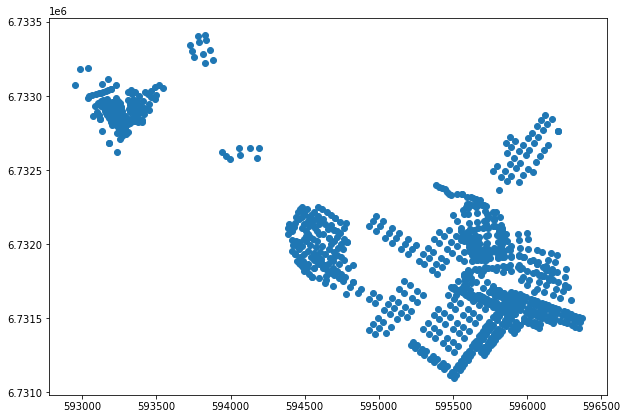

In [112]:
data.plot(figsize=(10,10))

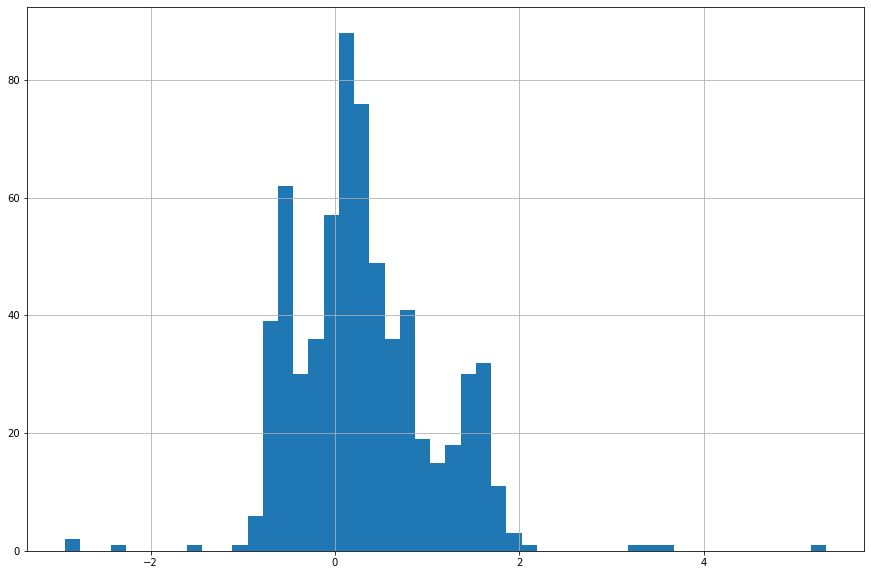

array([[<AxesSubplot:title={'center':'orthodox_proportion'}>]],
      dtype=object)

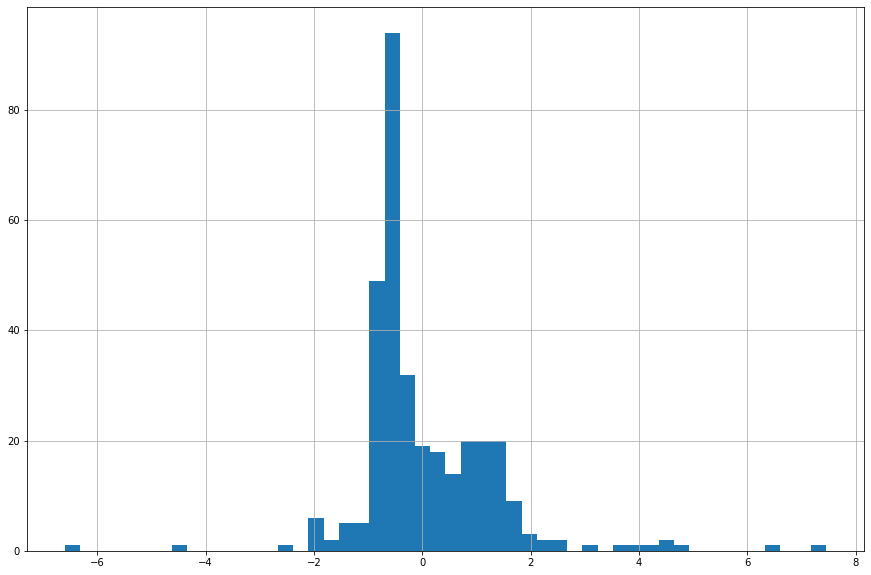

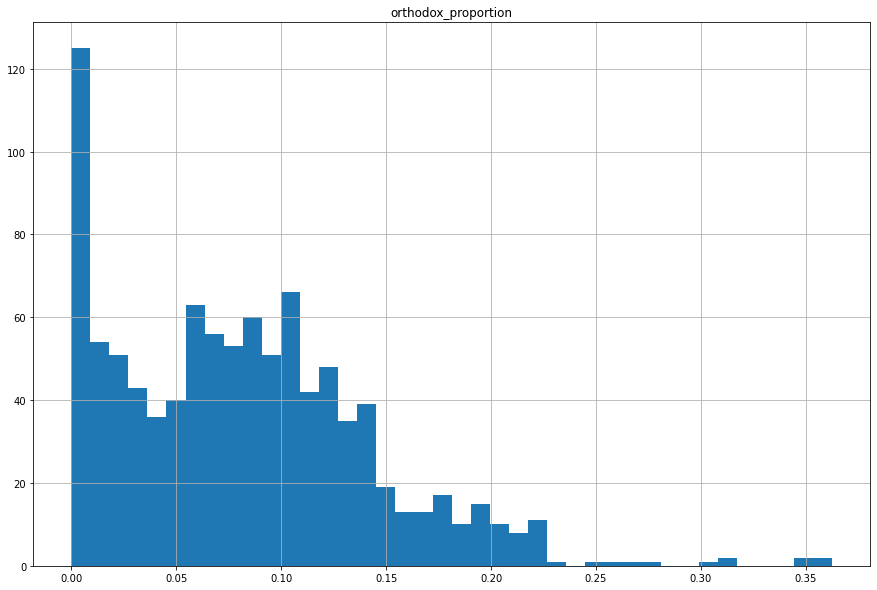

In [113]:
data.loc[data.is_old,'income_per_capita_ln'].hist(figsize=(15,10), bins=50)
plt.show()
data.loc[~data.is_old,'income_per_capita_ln'].hist(figsize=(15,10), bins=50)
data.hist(column='orthodox_proportion', figsize=(15, 10), bins=40)
# data.hist(column='orthodox')
# data.hist(column='lutheran')
# data.iplot(x='total_income', y='total_density', kind='scatter', mode='markers')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_L, sigma_O, beta_L, beta_O, sigma_W, beta_W]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


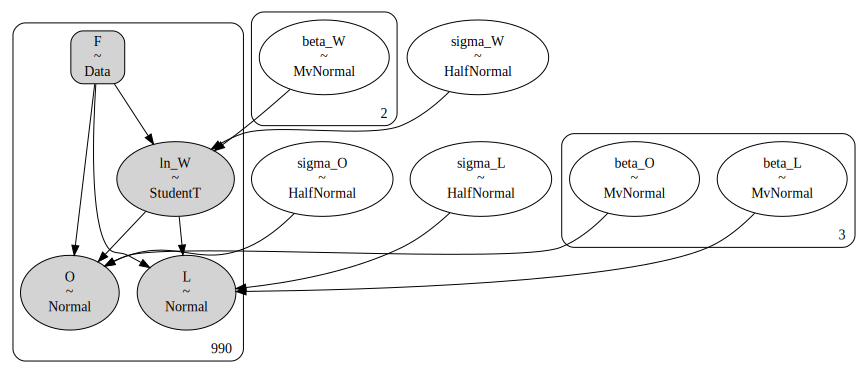

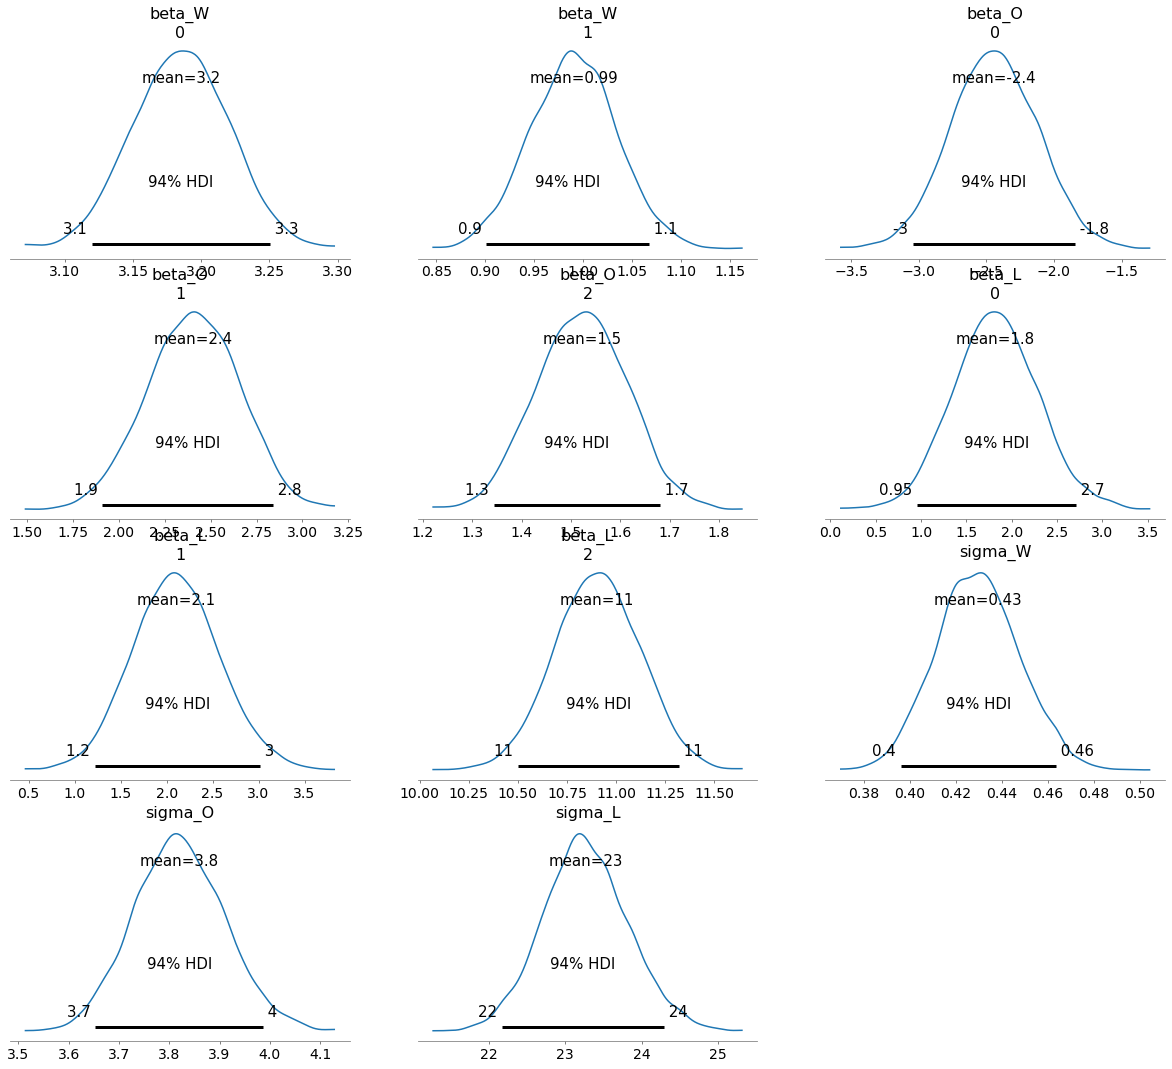

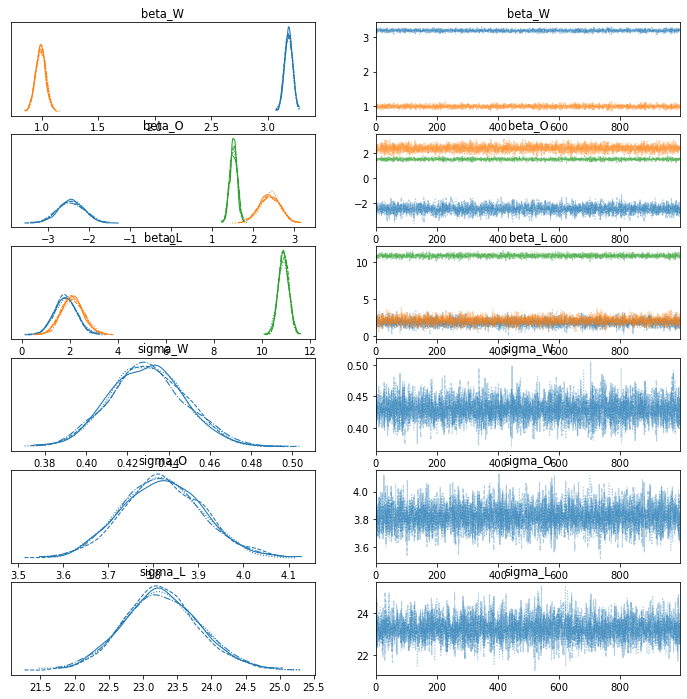

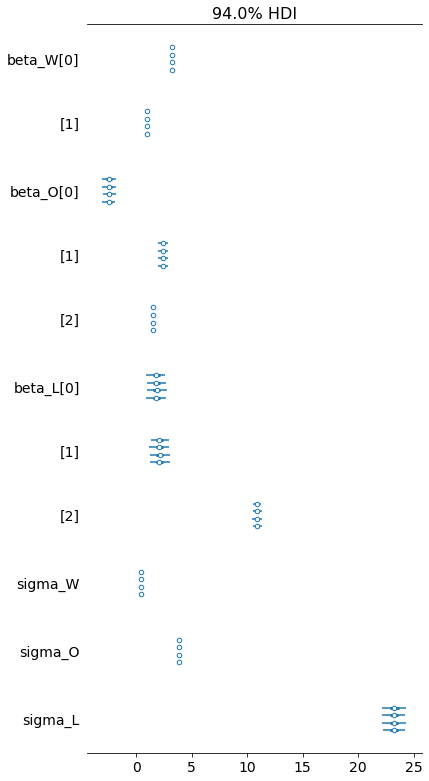

In [114]:
with pm.Model() as model_1:
    F = pm.Data('F', data.is_old.astype('int'))

    mu_beta_W = np.array([4, 1])
    sigma_beta_W = np.array(np.diagflat([1, 1]))
    beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
    sigma_W = pm.HalfNormal('sigma_W', sigma=1)
    ln_W = pm.StudentT('ln_W', nu=1, mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, observed=data.total_income_ln)

    mu_beta_O = np.array([0., 0., 0.])
    mu_beta_L = np.array([0., 0., 0.])
    sigma_beta_O = np.array(np.diagflat([0.25, 0.25, 0.25]))
    sigma_beta_L = np.array(np.diagflat([0.25, 0.25, 0.25]))

    beta_O = pm.MvNormal('beta_O', mu_beta_O, sigma_beta_O, shape=3)
    beta_L = pm.MvNormal('beta_L', mu_beta_L, sigma_beta_L, shape=3)
    sigma_O = pm.HalfNormal('sigma_O', 10)
    sigma_L = pm.HalfNormal('sigma_L', 10)

    O = pm.Normal('O', beta_O[0] + beta_O[1] * F + beta_O[2] * ln_W, sigma_O, observed=data.orthodox)
    L = pm.Normal('L', beta_L[0] + beta_L[1] * F + beta_L[2] * ln_W, sigma_L, observed=data.lutheran)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pm.model_to_graphviz(model_1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_P, sigma_O_prop, beta_P, beta_O_prop, sigma_W, beta_W]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.


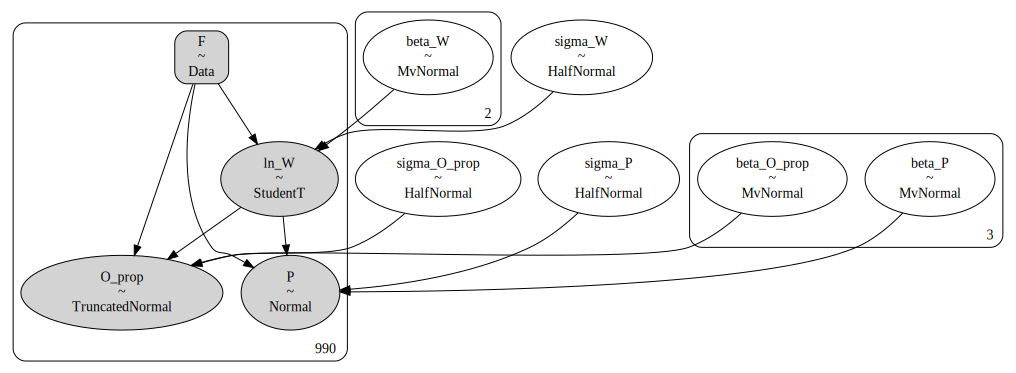

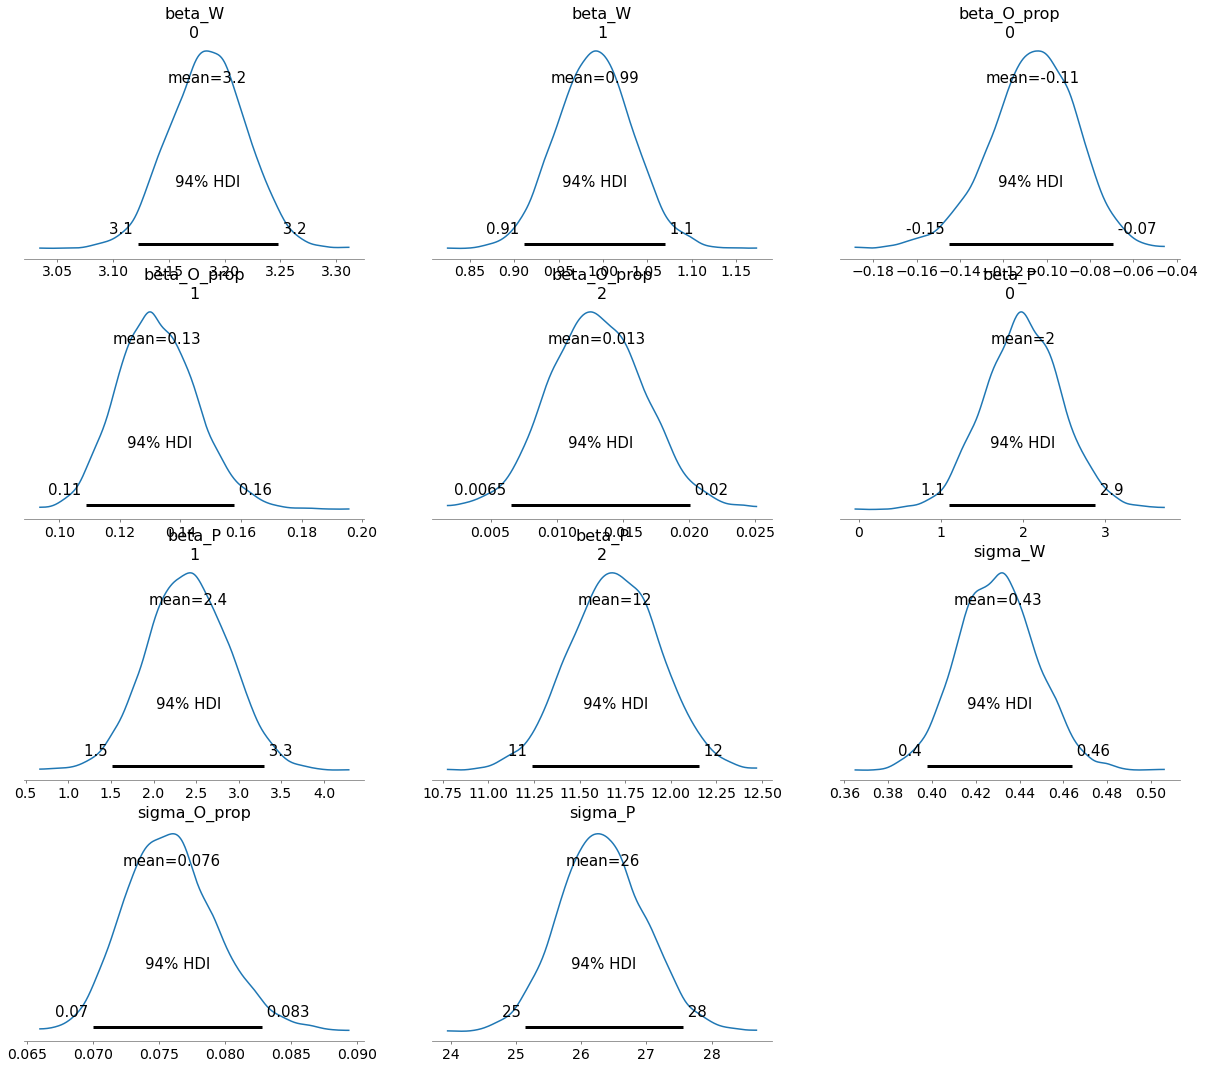

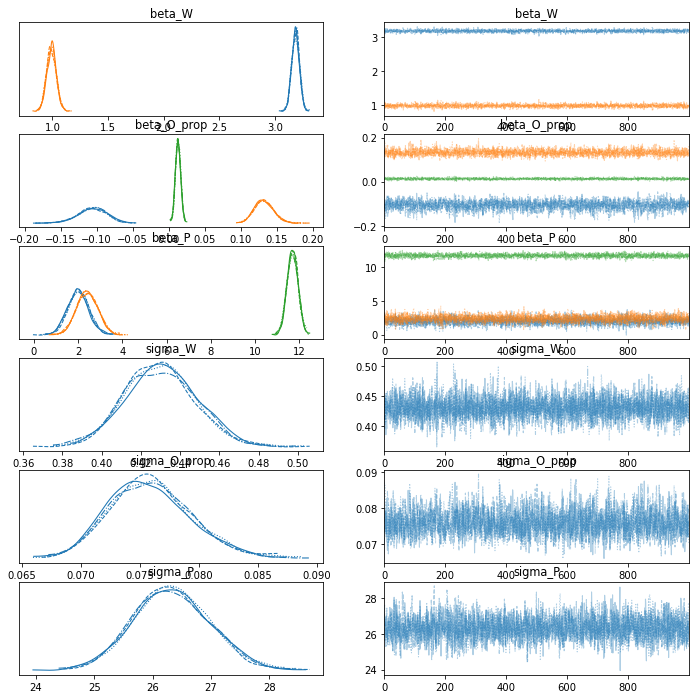

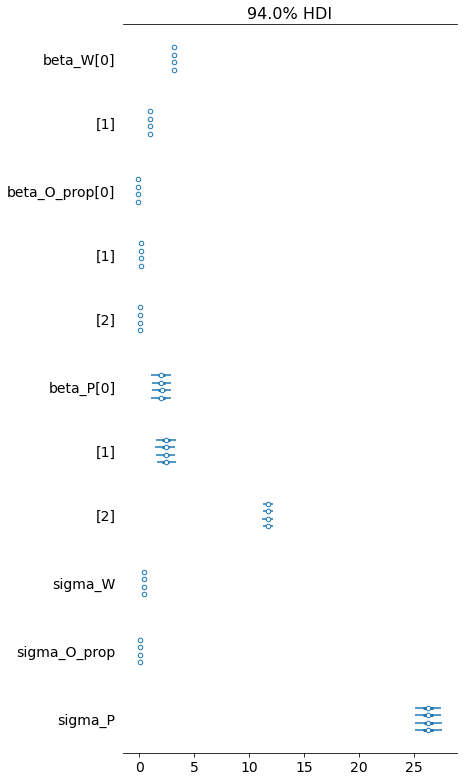

In [116]:
with pm.Model() as model_2:
    F = pm.Data('F', data.is_old.astype('int'))

    mu_beta_W = np.array([4, 1])
    sigma_beta_W = np.array(np.diagflat([1, 1]))
    beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
    sigma_W = pm.HalfNormal('sigma_W', sigma=1)
    ln_W = pm.StudentT('ln_W', nu=1, mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, observed=data.total_income_ln)

    mu_beta_O_prop = np.array([0.1, 0.1, 0.1])
    mu_beta_P = np.array([0., 0., 0.])
    sigma_beta_O_prop = np.array(np.diagflat([0.1, 0.1, 0.1]))
    sigma_beta_P = np.array(np.diagflat([0.25, 0.25, 0.25]))

    beta_O_prop = pm.MvNormal('beta_O_prop', mu_beta_O_prop, sigma_beta_O_prop, shape=3)
    beta_P = pm.MvNormal('beta_P', mu_beta_L, sigma_beta_L, shape=3)
    sigma_O_prop = pm.HalfNormal('sigma_O_prop', 0.05)
    sigma_P = pm.HalfNormal('sigma_P', 50)
    P = pm.Normal('P', beta_P[0] + beta_P[1] * F + beta_P[2] * ln_W, sigma_P, observed=data.population)

    mu_O_prop = beta_O_prop[0] + beta_O_prop[1] * F + beta_O_prop[2] * ln_W
    O_prop = pm.TruncatedNormal('O_prop', mu=mu_O_prop, sigma=sigma_O_prop, lower=0, upper=1, observed=data.orthodox_proportion)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pm.model_to_graphviz(model_2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_P, sigma_O_prop, beta_P, beta_O_prop, sigma_W, beta_W]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


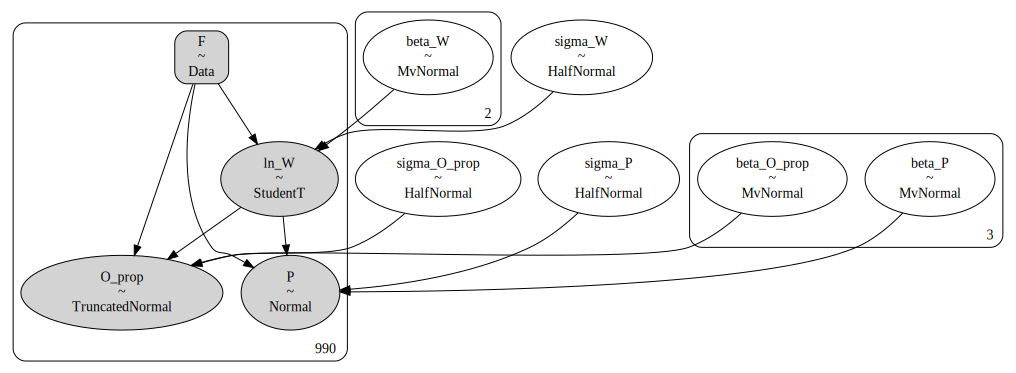

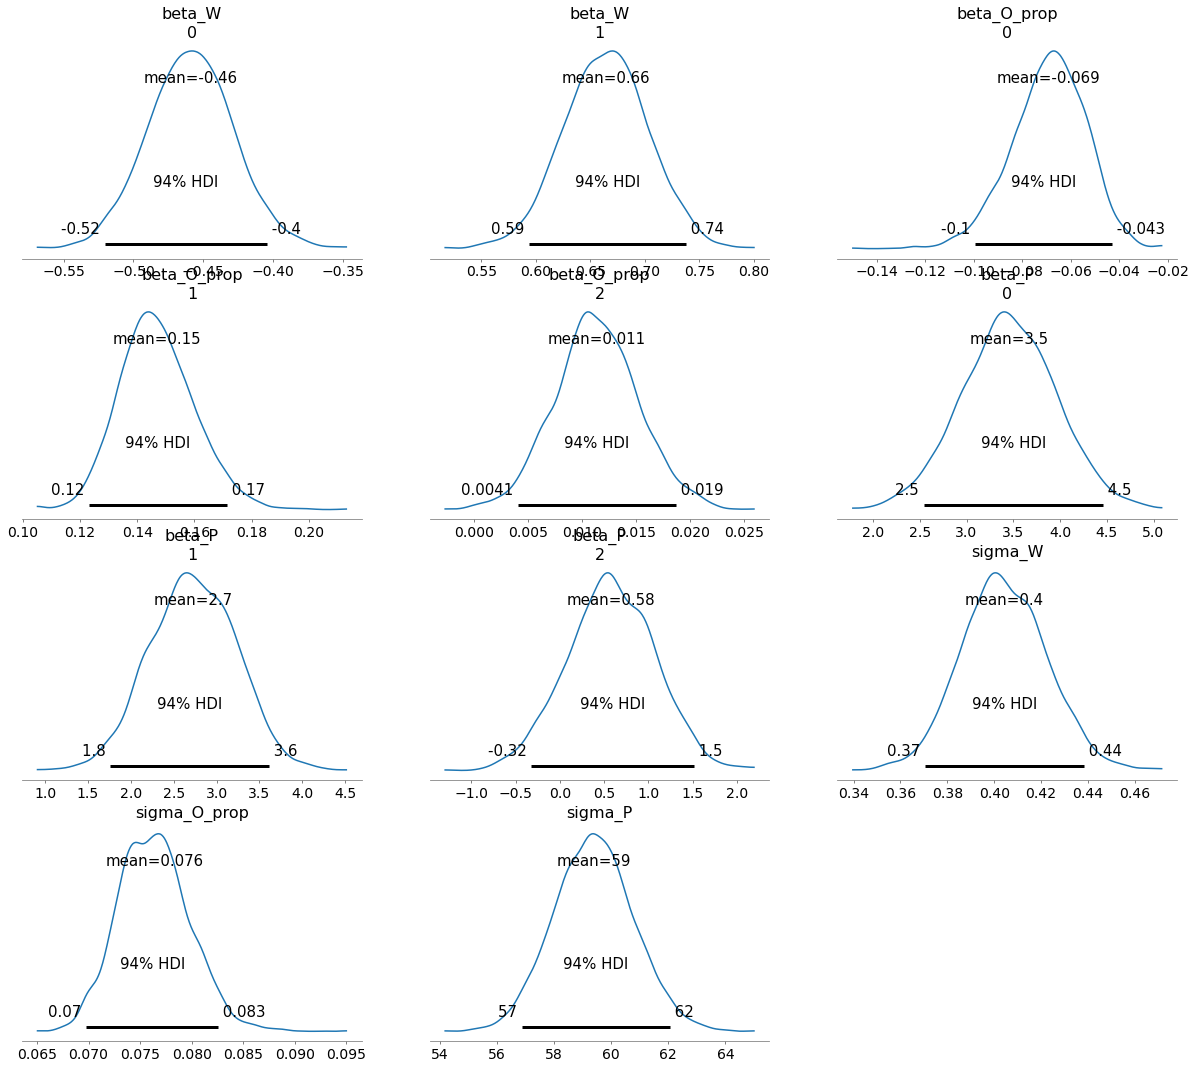

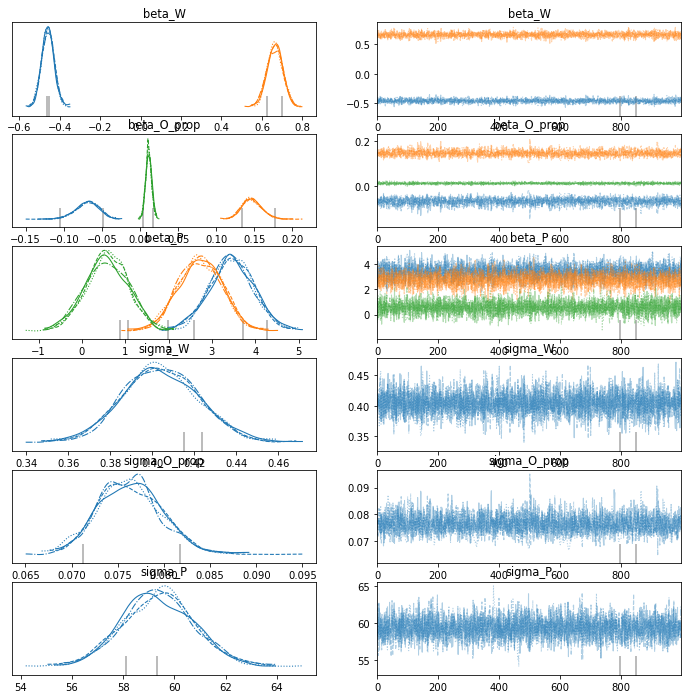

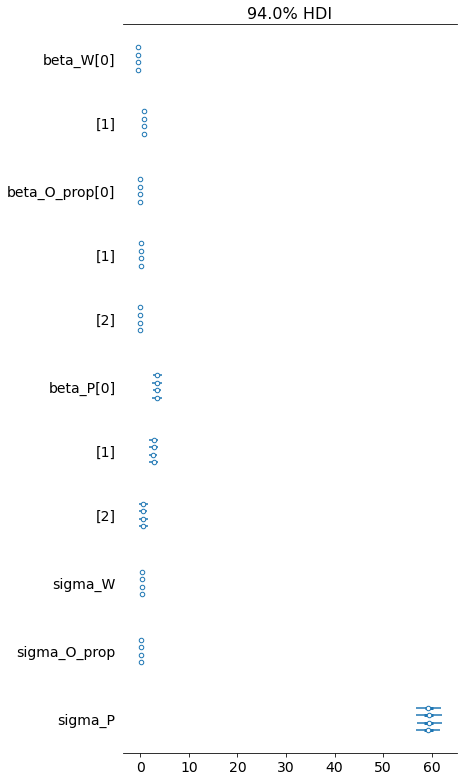

In [117]:
with pm.Model() as model_3:
    F = pm.Data('F', data.is_old.astype('int'))

    mu_beta_W = np.array([4, 1])
    sigma_beta_W = np.array(np.diagflat([1, 1]))
    beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
    sigma_W = pm.HalfNormal('sigma_W', sigma=1)
    ln_W = pm.StudentT('ln_W', nu=1, mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, observed=data.income_per_capita_ln)

    mu_beta_O_prop = np.array([0.1, 0.1, 0.1])
    mu_beta_P = np.array([0., 0., 0.])
    sigma_beta_O_prop = np.array(np.diagflat([0.1, 0.1, 0.1]))
    sigma_beta_P = np.array(np.diagflat([0.25, 0.25, 0.25]))

    beta_O_prop = pm.MvNormal('beta_O_prop', mu_beta_O_prop, sigma_beta_O_prop, shape=3)
    beta_P = pm.MvNormal('beta_P', mu_beta_L, sigma_beta_L, shape=3)
    sigma_O_prop = pm.HalfNormal('sigma_O_prop', 0.05)
    sigma_P = pm.HalfNormal('sigma_P', 50)

    P = pm.Normal('P', beta_P[0] + beta_P[1] * F + beta_P[2] * ln_W, sigma_P, observed=data.population)

    mu_O_prop = beta_O_prop[0] + beta_O_prop[1] * F + beta_O_prop[2] * ln_W
    O_prop = pm.TruncatedNormal('O_prop', mu=mu_O_prop, sigma=sigma_O_prop, lower=0, upper=1, observed=data.orthodox_proportion)

    prior = pm.sample_prior_predictive()
    posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=False, hdi_prob=0.94)
pm.model_to_graphviz(model_3)